## Import

In [1]:
import math
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import nibabel as nib
from nibabel.brikhead import *

from nilearn import plotting

[0] Data preparation 
Let’s suppose the following for the measured BOLD signal (TR = 2 s).   
(a) Each of the task was performed at 20 s during 4 s (i.e., 10th and 11th TRs). Please use the boxcar model for neural activity

(b) Consider the 0 – 20 s (i.e., 0th – 9th TRs) and 40 s – 60 s (i.e., 20th – 29th TRs) as baseline period

(c) Calculate the percentage (%) BOLD (pBOLD) signal based on (b)

(d) Conduct the estimation of the HRFs using the pBOLD signals calculated in (c) by applying each of the following methods [1]  [4]. 

When estimating HRFs, please use the pBOLD signal between 18 s – 52 s (i.e., 8th to 25th TRs) which includes a task-related period in between the baseline periods


### Load Subject

In [9]:
sub_id = 2
sub_id = f'{str(sub_id).zfill(2)}'

dir_sub_id = f'./data/s{sub_id}/ad_lh_rh_vs/s{sub_id}.results/*.brik'

In [29]:
glob(dir_sub_id)

['./data/s02/ad_lh_rh_vs/s02.results\\pb02.s02.r01.blur+tlrc.BRIK',
 './data/s02/ad_lh_rh_vs/s02.results\\pb02.s02.r02.blur+tlrc.BRIK',
 './data/s02/ad_lh_rh_vs/s02.results\\pb02.s02.r03.blur+tlrc.BRIK',
 './data/s02/ad_lh_rh_vs/s02.results\\pb02.s02.r04.blur+tlrc.BRIK']

In [30]:
fname = glob(dir_sub_id)[0]
ad_raw_brik = nib.load(fname)
ad_img_brik = ad_raw_brik.get_fdata()

In [31]:
fname = glob(dir_sub_id)[1]
lh_raw_brik = nib.load(fname)
lh_img_brik = lh_raw_brik.get_fdata()

In [32]:
fname = glob(dir_sub_id)[2]
rh_raw_brik = nib.load(fname)
rh_img_brik = rh_raw_brik.get_fdata()

In [33]:
fname = glob(dir_sub_id)[3]
vs_raw_brik = nib.load(fname)
vs_img_brik = vs_raw_brik.get_fdata()

### Load ROI Mask

In [34]:
masks = { # {task: [(x, y, z) ...]}
    k: [(x, y, z) for x, y, z in zip(*np.where(nib.load(v).get_fdata() != 0)[:-1])]
    for k, v in zip(['ad', 'lh', 'rh', 'vs'], glob('./stats/ttest/*.gz'))
}

In [35]:
ad_roi_total = np.sum(ad_img_brik[p] for p in masks['ad']) / len(masks['ad'])
lh_roi_total = np.sum(lh_img_brik[p] for p in masks['lh']) / len(masks['lh'])
rh_roi_total = np.sum(rh_img_brik[p] for p in masks['rh']) / len(masks['rh'])
vs_roi_total = np.sum(vs_img_brik[p] for p in masks['vs']) / len(masks['vs'])

<ipython-input-35-d5c7b6bfac6b>:1: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  ad_roi_total = np.sum(ad_img_brik[p] for p in masks['ad']) / len(masks['ad'])
<ipython-input-35-d5c7b6bfac6b>:2: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  lh_roi_total = np.sum(lh_img_brik[p] for p in masks['lh']) / len(masks['lh'])
<ipython-input-35-d5c7b6bfac6b>:3: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  rh_roi_total = np.sum(rh_img_brik[p] for p in masks['rh']) / len(masks['rh'])
<ipython-input-35-d5c7b6bfac6b>:4: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will

In [85]:
task_related_tmask = [_ for _ in range(8, 26)]

In [86]:
ad_roi_total[task_related_tmask]

array([715.3414388 , 714.24032186, 714.13745728, 712.94888306,
       715.91298625, 720.51322835, 716.42850545, 712.49010213,
       711.36983846, 711.86590169, 712.38032633, 715.66875407,
       715.06452433, 714.90030721, 713.24330037, 714.30494181,
       714.73956502, 711.46162923])

## Plot

In [91]:
def plot(roi_total, task='ad', title='BOLD Signal'):
    
    fig, ax = plt.subplots(1, 2, figsize=(18, 6))
    
    titlesize = 17
    labelsize = 15
    tickssize = 13
    
    ax[0].plot(roi_total)
    ax[0].set_title(f'{task.capitalize()} Averaged {title}', fontsize=titlesize)
    ax[0].set_xlabel('TR', fontsize=labelsize)
    ax[0].set_ylabel('BOLD signal Change', fontsize=labelsize)
    ax[0].tick_params('x', labelsize=tickssize)
    ax[0].tick_params('y', labelsize=tickssize)
    ax[0].grid()
#     ax[0].axvline(11, color='red')
#     ax[0].axvline(21, color='red')
    
    ax[1].plot(pd.Series(roi_total).pct_change())
    ax[1].set_title(f'{task.capitalize()} Percentage Change {title}', fontsize=titlesize)
    ax[1].set_xlabel('TR', fontsize=labelsize)
    ax[1].set_ylabel('% Change', fontsize=labelsize)
    ax[1].tick_params('x', labelsize=tickssize)
    ax[1].tick_params('y', labelsize=tickssize)
    ax[1].grid()
#     ax[1].axvline(11, color='red')
#     ax[1].axvline(21, color='red')

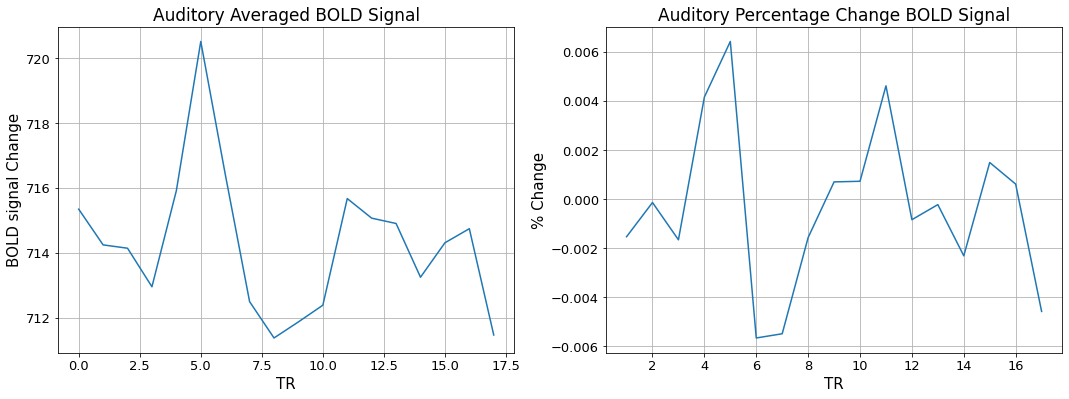

In [92]:
plot(ad_roi_total[task_related_tmask], 'Auditory')

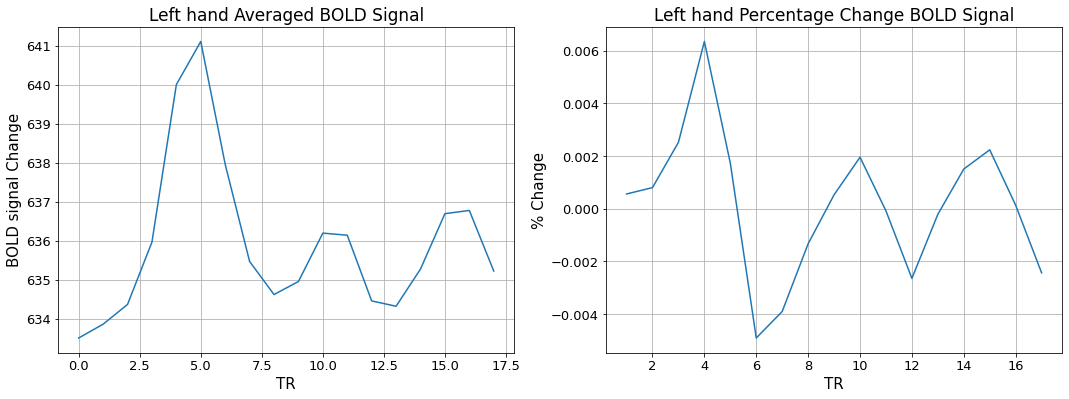

In [93]:
plot(lh_roi_total[task_related_tmask], 'left hand')

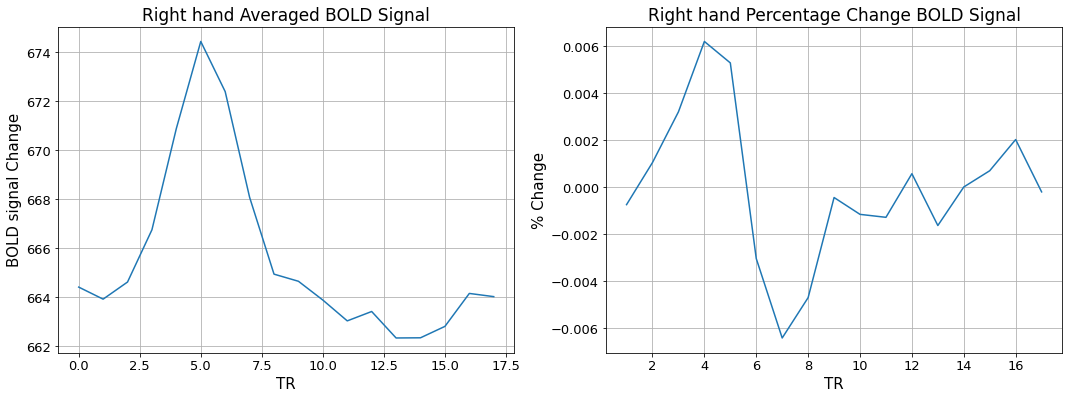

In [94]:
plot(rh_roi_total[task_related_tmask], 'right hand')

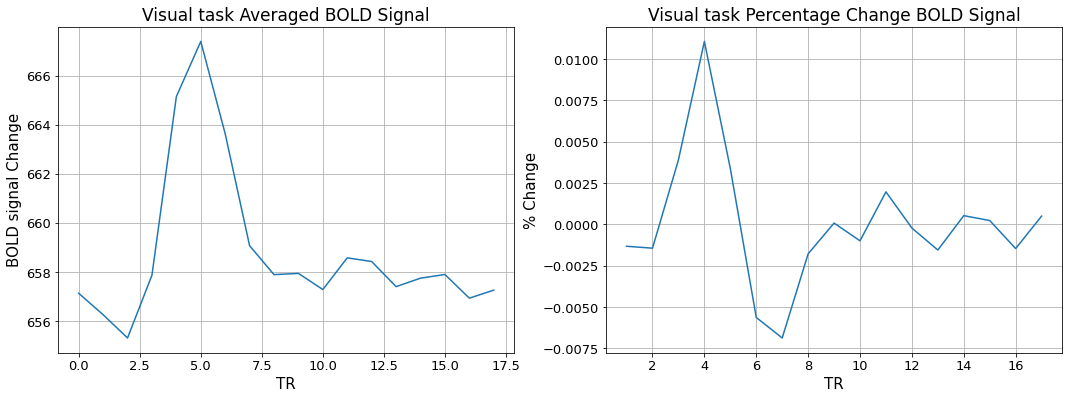

In [95]:
plot(vs_roi_total[task_related_tmask], 'visual task')

## Deconvolution

When $B(t) = \int_{0}^{t}N(t)*h(t-\tau)d\tau$, we can use Fast Fourier Transform to get h(t) since convolution turns into product of two argument functions. So we can write ...   
$h(t) = IFFT(\frac{FFT(B(t))}{FFT(N(t)})$

In [51]:
n = np.array(
    [0 for _ in range(0, 10)] +
    [1 for _ in range(10, 14)] +
    [0 for _ in range(14, 30)]
)

In [156]:
def deconvolution(bold, boxcar=None):
    
    if boxcar is None:
        n = np.array(
            [0 for _ in range(0, 10)] +
            [1 for _ in range(10, 12)] +
            [0 for _ in range(12, 30)]
        )
        
    return np.fft.ifft(np.fft.fft(bold) / np.fft.fft(boxcar))

In [157]:
n = np.array(
    [0, 0] + [1] * 16)

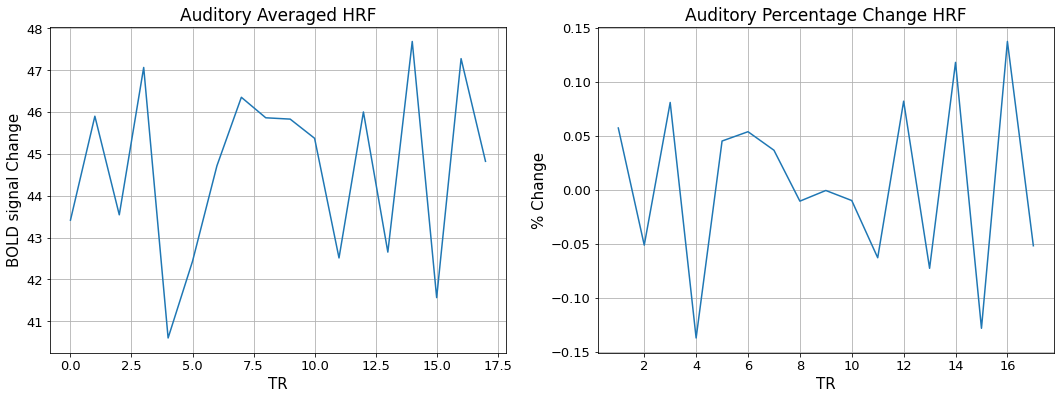

In [158]:
plot(deconvolution(ad_roi_total[task_related_tmask], boxcar=n).real, 'Auditory', 'HRF')

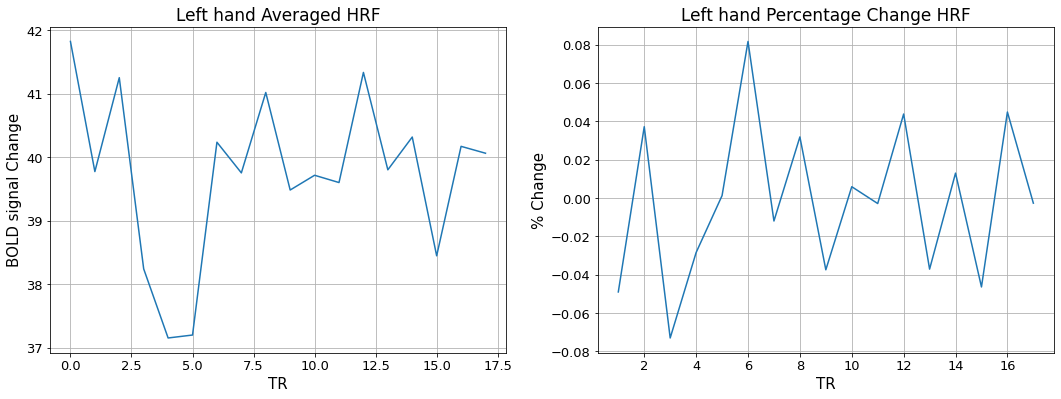

In [159]:
plot(deconvolution(lh_roi_total[task_related_tmask], boxcar=n).real, 'Left hand', 'HRF')

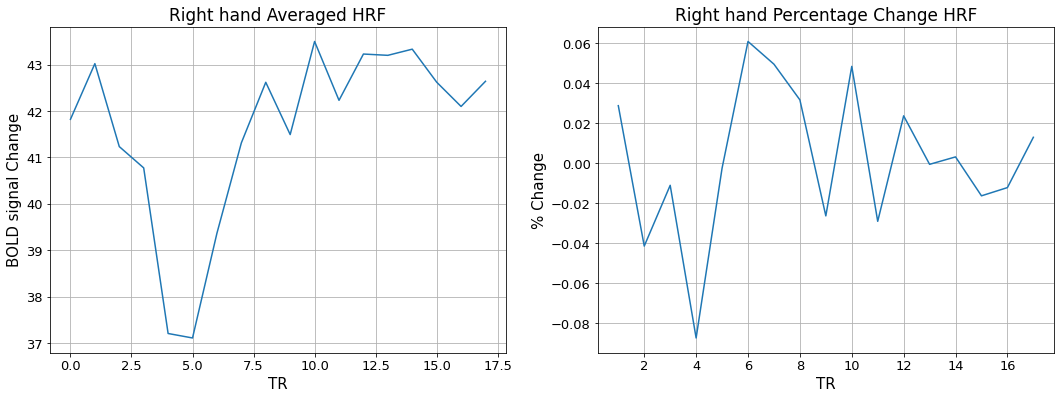

In [160]:
plot(deconvolution(rh_roi_total[task_related_tmask], boxcar=n).real, 'right hand', 'HRF')

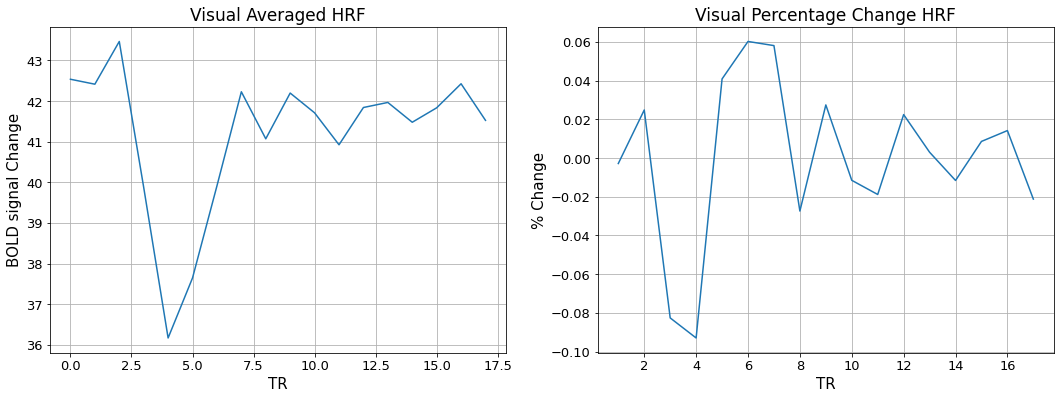

In [161]:
plot(deconvolution(vs_roi_total[task_related_tmask], boxcar=n).real, 'visual', 'HRF')

## Gamma by myself

Gamma function defined as follows   
$h(t) = \frac{(t-T_0) ^{n-1}}{\lambda ^n (n-1)!}e^{-t/\lambda}$ for $t > T_0$

In [106]:
fact = math.factorial

In [107]:
def one_gamma(t, t0, n, lamb):
    
    t[t < t0] = 0
    return (t - t0)**(n-1) / (lamb**n * fact(n-1)) * np.exp(-t/lamb)

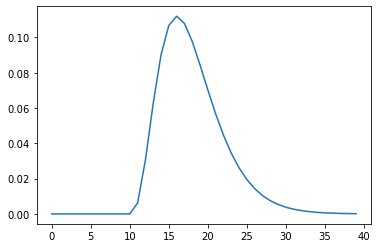

In [111]:
plt.plot(one_gamma(np.arange(-10, 30), 0, 4, 2))

In [168]:
def two_gamma(t, n1, n2, lamb1, lamb2, a, t0=0):
    
    t[t < t0] = 0
    C = sum(t**(n1-1)/(lamb1**n1 * fact(n1-1))*np.exp(-t/lamb1) - a * t**(n2-1)/(lamb2**n2 * fact(n2-1))*np.exp(-t/lamb2))
    return (t**(n1-1)/(lamb1**n1 * fact(n1-1))*np.exp(-t/lamb1) - a * t**(n2-1)/(lamb2**n2 * fact(n2-1))*np.exp(-t/lamb2)) / C

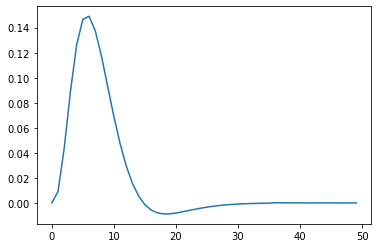

In [169]:
plt.plot(two_gamma(np.arange(0, 50), a=.3, n1=4, lamb1=2, n2=7, lamb2=2))

### from nistats.hrf

In [ ]:
from nistats.hemodynamic_models import *
plt.plot(spm_hrf(2, time_length=60))
plt.plot(glover_hrf(2, time_length=60, onset=1))


## Least Square Algorithm

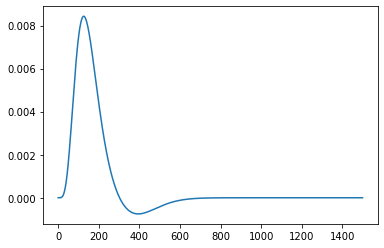

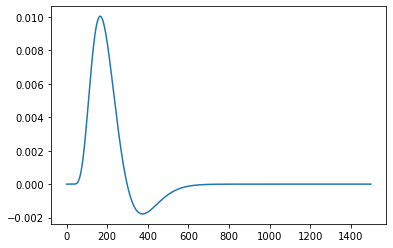

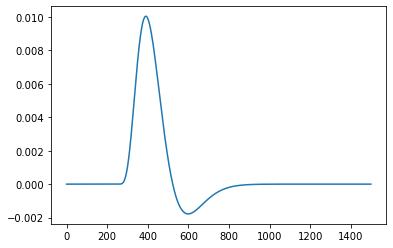

In [133]:
plt.plot(glover_hrf(2, time_length=60, onset=10))

In [140]:
(2000,)[-1]

2000

In [144]:
make_first_level_design_matrix((0, 2))

,constant
0,1.0
2,1.0
